In [9]:
%matplotlib inline

import sys 
import os 

nb_dir = os.getcwd()
if nb_dir not in sys.path:
    sys.path.append(nb_dir)



In [1]:
from plotlib.loaders import *
from plotlib.plotters import *

from phdconf import config 

In [2]:
"""Rank-biased overlap, a ragged sorted list similarity measure.

See http://doi.acm.org/10.1145/1852102.1852106 for details. All functions
directly corresponding to concepts from the paper are named so that they can be
clearly cross-identified.

The definition of overlap has been modified to account for ties. Without this,
results for lists with tied items were being inflated. The modification itself
is not mentioned in the paper but seems to be reasonable, see function
``overlap()``. Places in the code which diverge from the spec in the paper
because of this are highlighted with comments.

The two main functions for performing an RBO analysis are ``rbo()`` and
``rbo_dict()``; see their respective docstrings for how to use them.

The following doctest just checks that equivalent specifications of a
problem yield the same result using both functions:

    >>> lst1 = [{"c", "a"}, "b", "d"]
    >>> lst2 = ["a", {"c", "b"}, "d"]
    >>> ans_rbo = _round(rbo(lst1, lst2, p=.9))
    >>> dct1 = dict(a=1, b=2, c=1, d=3)
    >>> dct2 = dict(a=1, b=2, c=2, d=3)
    >>> ans_rbo_dict = _round(rbo_dict(dct1, dct2, p=.9, sort_ascending=True))
    >>> ans_rbo == ans_rbo_dict
    True

"""

from __future__ import division

import math
from bisect import bisect_left
from collections import namedtuple


RBO = namedtuple("RBO", "min res ext")
RBO.__doc__ += ": Result of full RBO analysis"
RBO.min.__doc__ = "Lower bound estimate"
RBO.res.__doc__ = "Residual corresponding to min; min + res is an upper bound estimate"
RBO.ext.__doc__ = "Extrapolated point estimate"


def _round(obj):
    if isinstance(obj, RBO):
        return RBO(_round(obj.min), _round(obj.res), _round(obj.ext))
    else:
        return round(obj, 3)


def set_at_depth(lst, depth):
    ans = set()
    for v in lst[:depth]:
        if isinstance(v, set):
            ans.update(v)
        else:
            ans.add(v)
    return ans


def raw_overlap(list1, list2, depth):
    """Overlap as defined in the article.

    """
    set1, set2 = set_at_depth(list1, depth), set_at_depth(list2, depth)
    return len(set1.intersection(set2)), len(set1), len(set2)


def overlap(list1, list2, depth):
    """Overlap which accounts for possible ties.

    This isn't mentioned in the paper but should be used in the ``rbo*()``
    functions below, otherwise overlap at a given depth might be > depth which
    inflates the result.

    There are no guidelines in the paper as to what's a good way to calculate
    this, but a good guess is agreement scaled by the minimum between the
    requested depth and the lengths of the considered lists (overlap shouldn't
    be larger than the number of ranks in the shorter list, otherwise results
    are conspicuously wrong when the lists are of unequal lengths -- rbo_ext is
    not between rbo_min and rbo_min + rbo_res.

    >>> overlap("abcd", "abcd", 3)
    3.0

    >>> overlap("abcd", "abcd", 5)
    4.0

    >>> overlap(["a", {"b", "c"}, "d"], ["a", {"b", "c"}, "d"], 2)
    2.0

    >>> overlap(["a", {"b", "c"}, "d"], ["a", {"b", "c"}, "d"], 3)
    3.0

    """
    return agreement(list1, list2, depth) * min(depth, len(list1), len(list2))
    # NOTE: comment the preceding and uncomment the following line if you want
    # to stick to the algorithm as defined by the paper
    # return raw_overlap(list1, list2, depth)[0]


def agreement(list1, list2, depth):
    """Proportion of shared values between two sorted lists at given depth.

    >>> _round(agreement("abcde", "abdcf", 1))
    1.0
    >>> _round(agreement("abcde", "abdcf", 3))
    0.667
    >>> _round(agreement("abcde", "abdcf", 4))
    1.0
    >>> _round(agreement("abcde", "abdcf", 5))
    0.8
    >>> _round(agreement([{1, 2}, 3], [1, {2, 3}], 1))
    0.667
    >>> _round(agreement([{1, 2}, 3], [1, {2, 3}], 2))
    1.0

    """
    len_intersection, len_set1, len_set2 = raw_overlap(list1, list2, depth)
    return 2 * len_intersection / (len_set1 + len_set2)


def cumulative_agreement(list1, list2, depth):
    return (agreement(list1, list2, d) for d in range(1, depth + 1))


def average_overlap(list1, list2, depth=None):
    """Calculate average overlap between ``list1`` and ``list2``.

    >>> _round(average_overlap("abcdefg", "zcavwxy", 1))
    0.0
    >>> _round(average_overlap("abcdefg", "zcavwxy", 2))
    0.0
    >>> _round(average_overlap("abcdefg", "zcavwxy", 3))
    0.222
    >>> _round(average_overlap("abcdefg", "zcavwxy", 4))
    0.292
    >>> _round(average_overlap("abcdefg", "zcavwxy", 5))
    0.313
    >>> _round(average_overlap("abcdefg", "zcavwxy", 6))
    0.317
    >>> _round(average_overlap("abcdefg", "zcavwxy", 7))
    0.312

    """
    depth = min(len(list1), len(list2)) if depth is None else depth
    return sum(cumulative_agreement(list1, list2, depth)) / depth


def rbo_at_k(list1, list2, p, depth=None):
    # ``p**d`` here instead of ``p**(d - 1)`` because enumerate starts at
    # 0
    depth = min(len(list1), len(list2)) if depth is None else depth
    d_a = enumerate(cumulative_agreement(list1, list2, depth))
    return (1 - p) * sum(p ** d * a for (d, a) in d_a)


def rbo_min(list1, list2, p, depth=None):
    """Tight lower bound on RBO.

    See equation (11) in paper.

    >>> _round(rbo_min("abcdefg", "abcdefg", .9))
    0.767
    >>> _round(rbo_min("abcdefgh", "abcdefg", .9))
    0.767

    """
    depth = min(len(list1), len(list2)) if depth is None else depth
    x_k = overlap(list1, list2, depth)
    log_term = x_k * math.log(1 - p)
    sum_term = sum(
        p ** d / d * (overlap(list1, list2, d) - x_k) for d in range(1, depth + 1)
    )
    return (1 - p) / p * (sum_term - log_term)


def rbo_res(list1, list2, p):
    """Upper bound on residual overlap beyond evaluated depth.

    See equation (30) in paper.

    NOTE: The doctests weren't verified against manual computations but seem
    plausible. In particular, for identical lists, ``rbo_min()`` and
    ``rbo_res()`` should add up to 1, which is the case.

    >>> _round(rbo_res("abcdefg", "abcdefg", .9))
    0.233
    >>> _round(rbo_res("abcdefg", "abcdefghijklmnopqrstuvwxyz", .9))
    0.239

    """
    S, L = sorted((list1, list2), key=len)
    s, l = len(S), len(L)
    x_l = overlap(list1, list2, l)
    # since overlap(...) can be fractional in the general case of ties and f
    # must be an integer --> math.ceil()
    f = int(math.ceil(l + s - x_l))
    # upper bound of range() is non-inclusive, therefore + 1 is needed
    term1 = s * sum(p ** d / d for d in range(s + 1, f + 1))
    term2 = l * sum(p ** d / d for d in range(l + 1, f + 1))
    term3 = x_l * (math.log(1 / (1 - p)) - sum(p ** d / d for d in range(1, f + 1)))
    return p ** s + p ** l - p ** f - (1 - p) / p * (term1 + term2 + term3)


def rbo_ext(list1, list2, p):
    """RBO point estimate based on extrapolating observed overlap.

    See equation (32) in paper.

    NOTE: The doctests weren't verified against manual computations but seem
    plausible.

    >>> _round(rbo_ext("abcdefg", "abcdefg", .9))
    1.0
    >>> _round(rbo_ext("abcdefg", "bacdefg", .9))
    0.9

    """
    S, L = sorted((list1, list2), key=len)
    s, l = len(S), len(L)
    x_l = overlap(list1, list2, l)
    x_s = overlap(list1, list2, s)
    # the paper says overlap(..., d) / d, but it should be replaced by
    # agreement(..., d) defined as per equation (28) so that ties are handled
    # properly (otherwise values > 1 will be returned)
    # sum1 = sum(p**d * overlap(list1, list2, d)[0] / d for d in range(1, l + 1))
    sum1 = sum(p ** d * agreement(list1, list2, d) for d in range(1, l + 1))
    sum2 = sum(p ** d * x_s * (d - s) / s / d for d in range(s + 1, l + 1))
    term1 = (1 - p) / p * (sum1 + sum2)
    term2 = p ** l * ((x_l - x_s) / l + x_s / s)
    return term1 + term2


def rbo(list1, list2, p):
    """Complete RBO analysis (lower bound, residual, point estimate).

    ``list`` arguments should be already correctly sorted iterables and each
    item should either be an atomic value or a set of values tied for that
    rank. ``p`` is the probability of looking for overlap at rank k + 1 after
    having examined rank k.

    >>> lst1 = [{"c", "a"}, "b", "d"]
    >>> lst2 = ["a", {"c", "b"}, "d"]
    >>> _round(rbo(lst1, lst2, p=.9))
    RBO(min=0.489, res=0.477, ext=0.967)

    """
    if not 0 <= p <= 1:
        raise ValueError("The ``p`` parameter must be between 0 and 1.")
    args = (list1, list2, p)
    return RBO(rbo_min(*args), rbo_res(*args), rbo_ext(*args))


def sort_dict(dct, *, ascending=False):
    """Sort keys in ``dct`` according to their corresponding values.

    Sorts in descending order by default, because the values are
    typically scores, i.e. the higher the better. Specify
    ``ascending=True`` if the values are ranks, or some sort of score
    where lower values are better.

    Ties are handled by creating sets of tied keys at the given position
    in the sorted list.

    >>> dct = dict(a=1, b=2, c=1, d=3)
    >>> list(sort_dict(dct)) == ['d', 'b', {'a', 'c'}]
    True
    >>> list(sort_dict(dct, ascending=True)) == [{'a', 'c'}, 'b', 'd']
    True

    """
    scores = []
    items = []
    # items should be unique, scores don't have to
    for item, score in dct.items():
        if not ascending:
            score *= -1
        i = bisect_left(scores, score)
        if i == len(scores):
            scores.append(score)
            items.append(item)
        elif scores[i] == score:
            existing_item = items[i]
            if isinstance(existing_item, set):
                existing_item.add(item)
            else:
                items[i] = {existing_item, item}
        else:
            scores.insert(i, score)
            items.insert(i, item)
    return items


def rbo_dict(dict1, dict2, p, *, sort_ascending=False):
    """Wrapper around ``rbo()`` for dict input.

    Each dict maps items to be sorted to the score according to which
    they should be sorted. The RBO analysis is then performed on the
    resulting sorted lists.

    The sort is descending by default, because scores are typically the
    higher the better, but this can be overridden by specifying
    ``sort_ascending=True``.

    >>> dct1 = dict(a=1, b=2, c=1, d=3)
    >>> dct2 = dict(a=1, b=2, c=2, d=3)
    >>> _round(rbo_dict(dct1, dct2, p=.9, sort_ascending=True))
    RBO(min=0.489, res=0.477, ext=0.967)

    """
    list1, list2 = (
        sort_dict(dict1, ascending=sort_ascending),
        sort_dict(dict2, ascending=sort_ascending),
    )
    return rbo(list1, list2, p)

In [3]:
from typing import Dict, List

def load_result_file(path: str) -> Dict[str, List[str]]:
    """
    Return dict of topic id -> ordered list of results. Assumes that 
    results are ordered in trec result file.
    """
    topics = {} 
    with open(path) as f:
        for line in f:
            parts = line.split(maxsplit=3)
            results = topics.get(parts[0], [])
            results.append(parts[2])
            if len(results) == 1:
                topics[parts[0]] = results

    return topics

In [51]:
BASE_DIR = os.path.join(os.environ["HOME"], "phd-generated")

base_res = load_result_file(os.path.join(BASE_DIR, "dirichlet_prior", "case-topics-filtered-phrasestop-unigram_dir_mu_1050.00.run"))

In [53]:
rm1_res =  [[load_result_file(os.path.join('/home/danlocke/go/src/github.com/dan-locke/phd/prf', f'case-topics-prf-text-docs-{docs}-terms-{terms}.run')) for terms in range(1, 11)] for docs in range(1, 6)] 

In [54]:
def compare_rbo_runs(a, b) -> pd.DataFrame:
    l = []
    for topic in base_res.keys():
        l.append((topic, *rbo(a[topic], b[topic], p=0.8)))
    
    return pd.DataFrame(l, columns=['topic', 'min', 'res', 'ext'])

overlaps = [[compare_rbo_runs(base_res, rm1_res[y][x]) for x in range(10)] for y in range(5)] 

In [55]:
len(overlaps)

5

In [56]:
from matplotlib import pyplot as plt
import pandas as pd


5 10


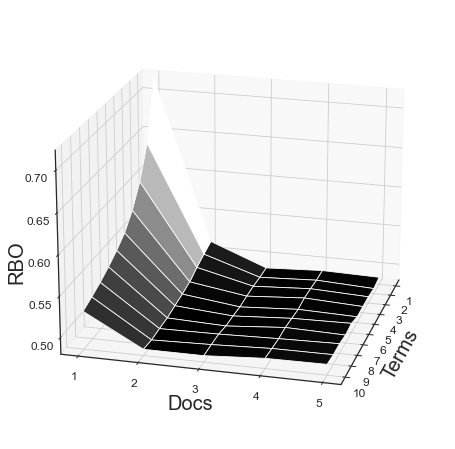

In [59]:
import numpy as np

fig = plt.figure()
fig.set_size_inches(8, 8)

ax = plt.axes(projection='3d')

x_t = [x for x in range(1, 11)]
y_t = [y for y in range(1, 6)]

x, y = np.meshgrid(x_t, y_t)

z = [[a.mean() for a in term_overlap] for term_overlap in overlaps]
z_min = np.asarray([[a['min'] for a in t] for t in z])
z_res = np.asarray([[a['res']+a['min'] for a in t] for t in z])
print(len(z), len(z[0]))

ax.plot_surface(x, y, z_min, cmap=cm.gray)
# ax.plot_surface(x, y, z_res)

ax.set_zlabel('RBO', rotation=90, size=20)
ax.set_ylabel('Docs', size=20)
ax.set_xlabel('Terms', size=20)
ax.set_xticks(x_t)
ax.set_yticks(y_t)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.zaxis.set_tick_params(labelsize=12)
ax.view_init(20, 15)

fig.savefig('figures/ausnl-rm1-dp-overlap.pdf')

In [43]:
topic_appeal_pos = {}
for topic, results in base_res.items():
    pos = [res for i, res in enumerate(results) if 'FCAFC' in res or 'QCA' in res]
    topic_appeal_pos[int(topic)] = pos

In [44]:
np.asarray([len([y for y in x if y < 20]) for x in topic_appeal_pos.values()]).mean()

TypeError: '<' not supported between instances of 'str' and 'int'

In [45]:
def load_qrel(path: str, rel: bool=False):
    qrels = {}
    with open(path) as f:
        for line in f:
            parts = line.strip().split()
            if int(parts[0]) not in qrels:
                qrels[int(parts[0])] = set()
            if rel:
                if parts[3] == '1':
                    qrels[int(parts[0])].add(parts[2])
            else:
                qrels[int(parts[0])].add(parts[2])
            
    return qrels

qrels = load_qrel(config.AUS_QREL_PATH) 

In [46]:
topic_appeal_judgements = {}
for topic, judgments in qrels.items():
    topic_appeal_judgements[topic] =  [x for x in judgments if 'FCAFC' in x or 'QCA' in x]

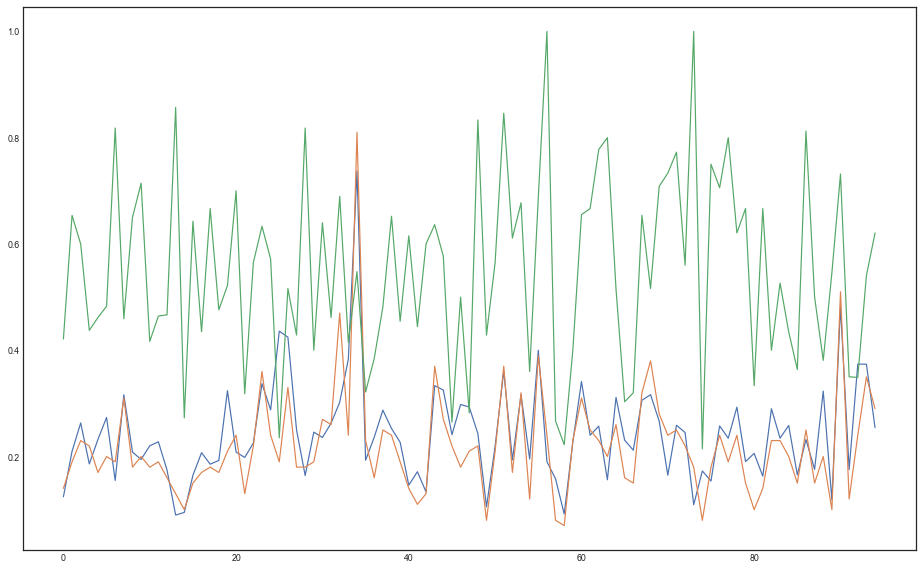

In [49]:
fig = plt.figure()
fig.set_size_inches(16, 10)
ax = plt.axes()

num_rel_appeal = []
num_appeal_ret = []
recall = []
for t, i in topic_appeal_pos.items():
    if t not in topic_appeal_judgements:
        continue
    num_rel_appeal.append(len(topic_appeal_judgements[t])/len(qrels[t]))
    num_appeal_ret.append(len(i)/100)
    recall.append(len(set(topic_appeal_judgements[t]).intersection(set(i)))/len(topic_appeal_judgements[t]))

ax.plot(num_rel_appeal)
ax.plot(num_appeal_ret)
ax.plot(recall)

In [62]:
inter = Interpolater(os.path.join(BASE_DIR, 'preprocessing', 'dirichlet_prior', 'case-topics-filtered-phrasestop-unigram_dir_mu_1050.00.run'), normalize=True)

hierarchy_interp_results = []
for _lambda in np.arange(0, 1.0, 0.01):
    inter.interpolate(os.path.join(BASE_DIR, 'case-topics-hierarchy.run'), _lambda, 'tmp.run')
    hierarchy_interp_results.append(load_result_file('tmp.run'))    


In [75]:
inter.interpolate(os.path.join(BASE_DIR, 'case-topics-hierarchy.run'), 0.2, 'tmp.run')
compare_rbo_runs(base_res, load_result_file('tmp.run')).mean()

topic    1.299545e+195
min       7.238314e-02
res       9.359057e-12
ext       7.238314e-02
dtype: float64

In [63]:
hierarchy_rbos = [compare_rbo_runs(base_res, x) for x in hierarchy_interp_results]

[0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693, 0.0723831416436693,

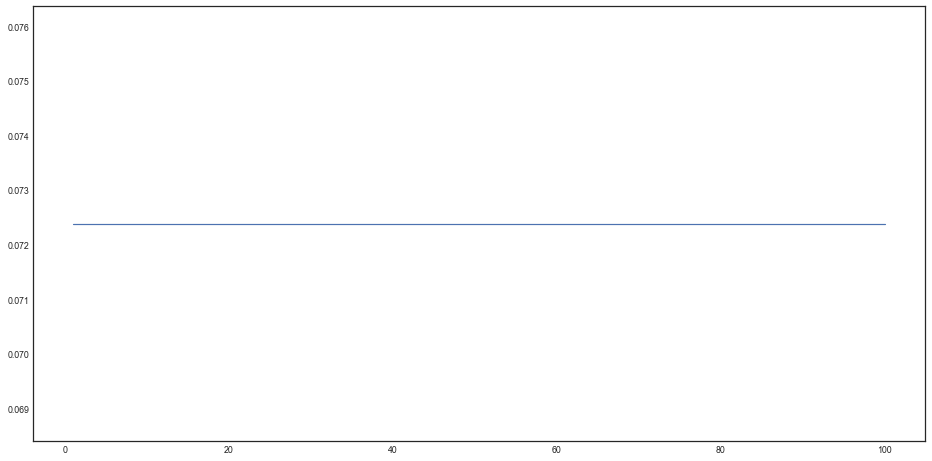

In [68]:
fig = plt.figure()
fig.set_size_inches(16, 8)
ax = plt.axes()
x = np.arange(1, 101, 1)
print([a['min'].mean() for a in hierarchy_rbos])
ax.plot(x, [a['min'].mean() for a in hierarchy_rbos])\

# This is low because interpolater.interpolate doesn't sort the results file properly. 
# But trec eval doesn't care about this as it ignores rank when computing. When we try and do a RBO, this evidently cares
# because they are all the same but in the wrong order... 